In [102]:
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../../../AutexysHost/source')
    
import numpy as np    
    
from utilities import DataLoggerUtility as dlu
from utilities import DataPlotterUtility as dpu
mplu = dpu.mplu
from utilities import FET_Modeling as fet_model
#from procedures import Device_History as DH

plt.rcParams['figure.figsize'] = [6.0*.65, 4.0*.65]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['lines.linewidth'] = 1.4*0.65
plt.rcParams['axes.facecolor'] = (1,1,1,0)

%config InlineBackend.figure_format = 'png'

0.3319501032568048 960
-0.10571647734685222 1440
-0.22531820954285167 1440
-0.1569918790509675 1440


Text(0.5, 1.0, 'SNR Values for Change in $I_{{D}}$')

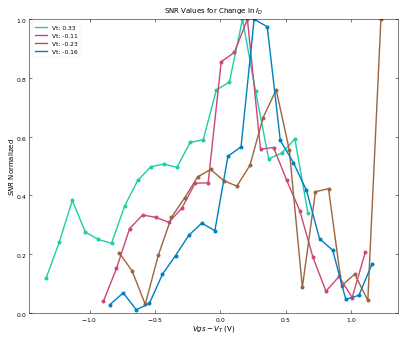

In [6]:
# define some AutoFlowStaticBias experiments that are good
SNR_experiment_names = [['C148FlowSaltWaterSNR/C148/G/35-36', 1, 'one'], 
                        ['C148Prelim/C148/G/17-18', 21, 'two'], 
                        ['C148FlowSaltWaterSNR/C148/A/9-10', 1, 'three'],
                        ['C148FlowSaltWaterSNR/C148/A/17-18', 1, 'four']]

'''
['C148FlowSaltWaterSNR/C148/G/24-25', 1, 'five'],
['C148FlowSaltWaterSNR/C148/G/47-48', 1, 'six'],
['C148FlowSaltWaterSNR/C148/A/4-5', 1, 'seven']
                
'''
colors = [mplu.setupColors(None, 20, colorMapName='white_teal_black', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='plasma', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='copper', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='winter', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greens', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Reds', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greys', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Oranges', colorMapStart=0.5, colorMapEnd=0.18)]

fig1, ax1 = dpu.makeBlankPlot(figsize=(2.2*3,1.8*3))
ax1.set_ylabel('$ Signal-Noise Ratio $')
ax1.set_ylim(0, 1)
experiment_counter = -1
legend = []

initial_vt = 0
for SNR_experiment in SNR_experiment_names:
    experiment_counter = experiment_counter + 1
    device_directory = SNR_experiment[0]
    device_number = SNR_experiment[1]
    
    data_long_gatesweep = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'GateSweep.json', minExperiment=device_number, maxExperiment=device_number) 
    data_long_fsb       = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'FlowStaticBias.json', minExperiment=device_number, maxExperiment=device_number) 

    SNR = []
    SNR_averaged_cycles = []
    SNR_total = []
    SNR_total_std = []
    allVgs = []
    
    # calculate average threshold voltage
    Vts = []
    for direction in range(0, 2):
        both_Vts = []
        for i in range(int(len(data_long_gatesweep)/(4/1)), int(len(data_long_gatesweep)/(4/3))):
            vgs_data = data_long_gatesweep[i]['Results']['vgs_data'][direction]    
            id_data = data_long_gatesweep[i]['Results']['id_data'][direction]
            bias_metrics = fet_model.FET_Metrics(vgs_data, id_data)
            V_T = bias_metrics['V_T']
            both_Vts.append(V_T)
        Vts.append(np.mean(both_Vts))
    Vt_average = np.median(Vts)
    if experiment_counter == 0:
        initial_vt = np.median(Vts)
        
    for i in range(len(data_long_fsb)):
        currentDevice = data_long_fsb[i]
        
        cycleCount = currentDevice["runConfigs"]["FlowStaticBias"]["cycleCount"]
        pumpPins = currentDevice["runConfigs"]["FlowStaticBias"]["pumpPins"]
        numberOfMotors = len(pumpPins)
        # this should be a constant value regardless
        currentVgs = np.mean(currentDevice["Results"]["vgs_data"]) 
        currentVds = np.mean(currentDevice["Results"]["vds_data"]) 
        
        # current data, with each index containing current data for each respective motor, in their own index for each cycle
        # id_data_total = [ [ [], [] ], [ [], [] ], [ [], [] ] ]
        # ^ with three cycles, with two motors
        id_data_total = []
        for cycleIndex in range(0, cycleCount):
            cycleArray = []
            for pinCount in range(0, numberOfMotors):
                cycleArray.append([])
            id_data_total.append(cycleArray)
        
        # go through pump_on_intervals_pin, add to proper id_data index based on where pin is
        counter = 0
        pinAlternatingCounter = 0
        measuredIdData = currentDevice["Results"]["id_data"]
        pump_on_intervals_pin = currentDevice["Results"]["pump_on_intervals_pin"]
        prevPin = pump_on_intervals_pin[0]

        for pumpIntervalCount in pump_on_intervals_pin:
            if prevPin != pumpIntervalCount:
                #print("counter: ", str(counter))
                pinAlternatingCounter += 1
                prevPin = pumpIntervalCount
                #print(int(pinAlternatingCounter / len(pumpPins)))
                
            variablename = int(pinAlternatingCounter / len(pumpPins))
            id_data_total[ variablename ][pumpPins.index(pumpIntervalCount)].append(measuredIdData[counter])
            counter += 1
        
        # calculate signal to noise ratio!
        # The assumption here is that the FIRST pin is the control
        
        # SNR: each index represents noise per cycle; each array in respective index represents SNR b/w control and 
        # solutions outputted from digitalPins as ordered in pumpPins
        SNR = []
        
        for cycleIndex in range(0, cycleCount):
            individualPumpRatio = []
            #print("cycle count: ", str(cycleIndex))
            # go through every other pin, compare to control
            for pinIndex in range(1, len(pumpPins)):
                control_data = id_data_total[cycleIndex][0]
                control_data = control_data[int(len(control_data)*1/4):int(len(control_data)*3/4)]
                other_data = id_data_total[cycleIndex][pinIndex]
                other_data = other_data[int(len(other_data)*1/4):int(len(other_data)*3/4)]
                u1 = np.mean(control_data)
                u2 = np.mean(other_data)
                #print("means")
                #print(u1, u2)
                
                signal = abs(u1 - u2)
                std1 = np.std(control_data)
                std2 = np.std(other_data)
                noise = (std1 + std2) / 2

                individualPumpRatio.append(signal / noise)
            SNR.append(individualPumpRatio)
        #print("SNR")
        #print(SNR)
        
        # go through every possible pin combination (i), and average up the cycles (k)
        SNR_averaged_cycles = []
        SNR_averaged_cycles_std = []
        for i in range(0, len(pumpPins)-1):
            SNR_averaged_cycles.append([])
            SNR_averaged_cycles_std.append([])
            for k in range(1, cycleCount):
                SNR_averaged_cycles[i].append(SNR[k][i])
            a = np.mean(SNR_averaged_cycles[i])
            b = np.std(SNR_averaged_cycles[i])
            SNR_averaged_cycles[i] = a
            SNR_averaged_cycles_std[i] = b
                    
            SNR_total.append(SNR_averaged_cycles)
            SNR_total_std.append(SNR_averaged_cycles_std)
            
        allVgs.append(currentVgs)

    SNR_total = [k / np.max(SNR_total) for k in SNR_total]
    print(Vt_average, counter)
    for x in range(0, len(pumpPins)-1):
        correspondingSNR = []
        snr_max_per = 0
        snr_max_per_index = 0
        ax1.plot([x - (Vt_average) for x in allVgs], SNR_total, color=colors[experiment_counter][0], label='Vt: ' + str(round(Vt_average, 2)))
        for y in range(0, len(allVgs)):
            correspondingSNR.append(SNR_total[y][x])
            ax1.plot([allVgs[y] - (Vt_average)], [SNR_total[y][x]], color=colors[experiment_counter][0], linestyle=None, linewidth=0, marker='o', markersize=4)
            #ax1.errorbar([allVgs[y] - Vt_average], [SNR_total[y][x]], yerr=SNR_total_std[y][x], color=colors[experiment_counter][0], linewidth=1, capsize=2, capthick=0.5, elinewidth=0.5)
            if SNR_total[y][x] > snr_max_per:
                snr_max_per = SNR_total[y][x]
                snr_max_per_index = y
        #ax1.axvline(allVgs[snr_max_per_index])

ax1.legend()
file_name = 'SNRPlotNotebookTotal'
ax1.set_xlabel('$ Vgs - V_{{T}} $ (V)')
ax1.set_ylabel('$ SNR $ Normalized')
ax1.set_title('SNR Values for Change in $I_{{D}}$')
# dpu.saveExternalPlot(fig1, file_name)

Text(0.5, 1.0, 'SNR Values for Change in $I_{{D}}$')

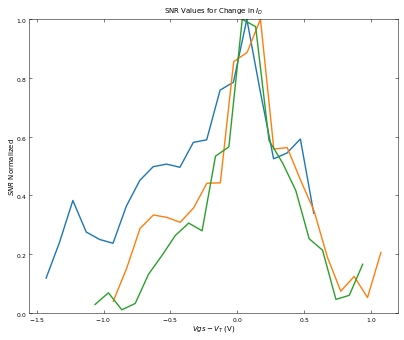

In [35]:
# define some AutoFlowStaticBias experiments that are good
SNR_experiment_names = [['C148FlowSaltWaterSNR/C148/G/35-36', 1, 'one'], 
                        ['C148Prelim/C148/G/17-18', 21, 'two'], 
                        #['C148FlowSaltWaterSNR/C148/A/9-10', 1, 'three'],
                        ['C148FlowSaltWaterSNR/C148/A/17-18', 1, 'four']]

'''
['C148FlowSaltWaterSNR/C148/G/24-25', 1, 'five'],
['C148FlowSaltWaterSNR/C148/G/47-48', 1, 'six'],
['C148FlowSaltWaterSNR/C148/A/4-5', 1, 'seven']
                
'''
colors = [mplu.setupColors(None, 20, colorMapName='white_teal_black', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='plasma', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='copper', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='winter', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greens', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Reds', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greys', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Oranges', colorMapStart=0.5, colorMapEnd=0.18)]

fig1, ax1 = dpu.makeBlankPlot(figsize=(2.2*3,1.8*3))
ax1.set_ylabel('$ Signal-Noise Ratio $')
ax1.set_ylim(0, 1)
experiment_counter = -1
legend = []

initial_vt = 0
for SNR_experiment in SNR_experiment_names:
    experiment_counter = experiment_counter + 1
    device_directory = SNR_experiment[0]
    device_number = SNR_experiment[1]
    
    data_long_gatesweep = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'GateSweep.json', minExperiment=device_number, maxExperiment=device_number) 
    data_long_fsb       = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'FlowStaticBias.json', minExperiment=device_number, maxExperiment=device_number) 

    SNR = []
    SNR_averaged_cycles = []
    SNR_total = []
    SNR_total_std = []
    allVgs = []
    
    # calculate average threshold voltage
    Vts = []
    for direction in range(0, 2):
        both_Vts = []
        for i in range(int(len(data_long_gatesweep)/(4/1)), int(len(data_long_gatesweep)/(4/3))):
            vgs_data = data_long_gatesweep[i]['Results']['vgs_data'][direction]    
            id_data = data_long_gatesweep[i]['Results']['id_data'][direction]
            bias_metrics = fet_model.FET_Metrics(vgs_data, id_data)
            V_T = bias_metrics['V_T']
            both_Vts.append(V_T)
        Vts.append(np.median(both_Vts))
    Vt_average = np.max(Vts)
    if experiment_counter == 0:
        initial_vt = np.max(Vts)
        
    for i in range(len(data_long_fsb)):
        currentDevice = data_long_fsb[i]
        
        cycleCount = currentDevice["runConfigs"]["FlowStaticBias"]["cycleCount"]
        pumpPins = currentDevice["runConfigs"]["FlowStaticBias"]["pumpPins"]
        numberOfMotors = len(pumpPins)
        # this should be a constant value regardless
        currentVgs = np.mean(currentDevice["Results"]["vgs_data"]) 
        currentVds = np.mean(currentDevice["Results"]["vds_data"]) 
        
        # current data, with each index containing current data for each respective motor, in their own index for each cycle
        # id_data_total = [ [ [], [] ], [ [], [] ], [ [], [] ] ]
        # ^ with three cycles, with two motors
        id_data_total = []
        for cycleIndex in range(0, cycleCount):
            cycleArray = []
            for pinCount in range(0, numberOfMotors):
                cycleArray.append([])
            id_data_total.append(cycleArray)
        
        # go through pump_on_intervals_pin, add to proper id_data index based on where pin is
        counter = 0
        pinAlternatingCounter = 0
        measuredIdData = currentDevice["Results"]["id_data"]
        pump_on_intervals_pin = currentDevice["Results"]["pump_on_intervals_pin"]
        prevPin = pump_on_intervals_pin[0]

        for pumpIntervalCount in pump_on_intervals_pin:
            if prevPin != pumpIntervalCount:
                #print("counter: ", str(counter))
                pinAlternatingCounter += 1
                prevPin = pumpIntervalCount
                #print(int(pinAlternatingCounter / len(pumpPins)))
                
            variablename = int(pinAlternatingCounter / len(pumpPins))
            id_data_total[ variablename ][pumpPins.index(pumpIntervalCount)].append(measuredIdData[counter])
            counter += 1
        
        # calculate signal to noise ratio!
        # The assumption here is that the FIRST pin is the control
        
        # SNR: each index represents noise per cycle; each array in respective index represents SNR b/w control and 
        # solutions outputted from digitalPins as ordered in pumpPins
        SNR = []
        
        for cycleIndex in range(0, cycleCount):
            individualPumpRatio = []
            #print("cycle count: ", str(cycleIndex))
            # go through every other pin, compare to control
            for pinIndex in range(1, len(pumpPins)):
                control_data = id_data_total[cycleIndex][0]
                control_data = control_data[int(len(control_data)*1/4):int(len(control_data)*3/4)]
                other_data = id_data_total[cycleIndex][pinIndex]
                other_data = other_data[int(len(other_data)*1/4):int(len(other_data)*3/4)]
                u1 = np.mean(control_data)
                u2 = np.mean(other_data)
                #print("means")
                #print(u1, u2)
                
                signal = abs(u1 - u2)
                std1 = np.std(control_data)
                std2 = np.std(other_data)
                noise = (std1 + std2) / 2

                individualPumpRatio.append(signal / noise)
            SNR.append(individualPumpRatio)
        #print("SNR")
        #print(SNR)
        
        # go through every possible pin combination (i), and average up the cycles (k)
        SNR_averaged_cycles = []
        SNR_averaged_cycles_std = []
        for i in range(0, len(pumpPins)-1):
            cycles_SNR = []
            for k in range(1, cycleCount):
                cycles_SNR.append(SNR[k][i])
            a = np.mean(cycles_SNR)
            b = np.std(cycles_SNR)
            SNR_averaged_cycles.append(np.mean(cycles_SNR))
            SNR_averaged_cycles_std.append(np.std(cycles_SNR))
            
            SNR_total.append(SNR_averaged_cycles)
            SNR_total_std.append(SNR_averaged_cycles_std)
            
        allVgs.append(currentVgs)
    
    SNR_total = np.array(SNR_total)
    SNR_total /= np.max(SNR_total)
    #SNR_total = [k / np.max(SNR_total) for k in SNR_total]
    
    for x in range(0, len(pumpPins)-1):
        correspondingSNR = []
        snr_max_per = 0
        snr_max_per_index = 0
        ax1.plot([x - (Vt_average) for x in allVgs], SNR_total)
        for y in range(0, len(allVgs)):
            correspondingSNR.append(SNR_total[y][x])
            #ax1.plot([allVgs[y] - (Vt_average)], [SNR_total[y][x]], color=colors[experiment_counter][0], linestyle=None, linewidth=0, marker='o', markersize=4)
            #ax1.errorbar([allVgs[y] - Vt_average], [SNR_total[y][x]], yerr=SNR_total_std[y][x], color=colors[experiment_counter][0], linewidth=1, capsize=2, capthick=0.5, elinewidth=0.5)
            if SNR_total[y][x] > snr_max_per:
                snr_max_per = SNR_total[y][x]
                snr_max_per_index = y
        #ax1.axvline(allVgs[snr_max_per_index])

file_name = 'SNRPlotNotebookTotal'
ax1.set_xlabel('$ Vgs - V_{{T}} $ (V)')
ax1.set_ylabel('$ SNR $ Normalized')
ax1.set_title('SNR Values for Change in $I_{{D}}$')
plt.show()
# dpu.saveExternalPlot(fig1, file_name)

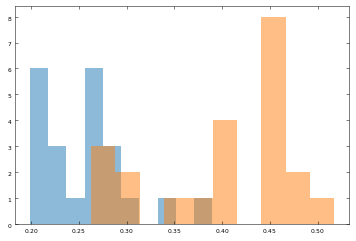

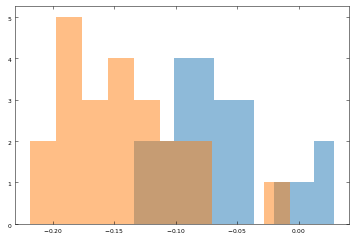

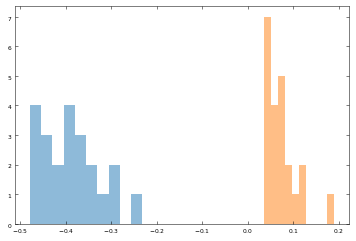

In [28]:
from matplotlib import pyplot as plt

vts = [[[0.2737062686198726, 0.38963832806238313, 0.25315666670711734, 0.3455922955444665, 0.23052027179976875, 0.3121356700612798, 0.21490493717493978, 0.2685519052342208, 0.20320577401419115, 0.268237335013268, 0.2001157660566489, 0.26783751817449525, 0.198837538797239, 0.2732617969553854, 0.20483047411572794, 0.2879897829943266, 0.21277061071104703, 0.28062265224663197, 0.22758813663850033, 0.28827725843745605, 0.23214727868101365, 0.27371964942753946],
[0.3028659337505065, 0.5172877833944054, 0.2818081859037645, 0.48356723899359816, 0.2627000710143593, 0.4741279383166608, 0.26960637030062234, 0.4656044464526626, 0.3134777521103971, 0.46581864937185596, 0.3437417090289614, 0.451640104048845, 0.400425861385022, 0.4538352152911521, 0.38963812188807473, 0.44795145033711314, 0.3949506765979522, 0.45302875646382346, 0.39915310683142907, 0.4589305037747907, 0.4106434976462394, 0.45735325492965573]],
[[-0.13347908651930146, -0.08249190704046948, -0.1205807107895876, -0.10612860565997334, -0.11211597506965364, -0.06874890589038057, -0.09609141205532226, -0.08871583751423821, -0.09505397242719535, -0.09929729662953744, -0.076085894428532, -0.06680818416003537, -0.08425668071064012, -0.057645320606746125, -0.06713765267577598, -0.04238696131167494, -0.04128830779857341, 0.005944060264986048, -0.047739110544994134, 0.02277352324179525, -0.01916329570667594, 0.02886123725709166],
[-0.21842479284348545, -0.130454875241853, -0.1772597048906255, -0.15020740415868242, -0.19157082348034918, -0.17390301169508768, -0.15208823076965902, -0.0728310629807216, -0.14077035359812767, -0.11031762781784782, -0.18504441657196533, -0.14068014022606612, -0.19791631457665815, -0.13022345609770966, -0.19086058041074286, -0.10594097967933137, -0.17423763430670663, -0.08554990035321709, -0.16971999599612242, -0.11905317172854049, -0.17941015887174758, -0.0074240701908163615]],
[[-0.38907420755700056, -0.2974092039460146, -0.39341270281932333, -0.31481724833133773, -0.4166157105319552, -0.33408534073782215, -0.4359233809960987, -0.3682998788752363, -0.45959004509036794, -0.3964303623456502, -0.4581224164173697, -0.39361434619335606, -0.4789333141661361, -0.3765034842843067, -0.4598969216698751, -0.3638997004077087, -0.44985172457642225, -0.3488045561812143, -0.4305681005910966, -0.30475319203613527, -0.41090401834939605, -0.2319442058115131],
[0.07937389746028768, 0.12284539526262706, 0.06946443426546407, 0.08998882399734015, 0.07113307742133744, 0.054164461471542344, 0.04891484012500773, 0.04464310034021438, 0.03787359726976518, 0.053822676891585035, 0.04415819605067377, 0.05610890789695577, 0.04102885694878316, 0.07764908072904968, 0.034862900511172405, 0.09674738605100923, 0.04672904561935332, 0.10245688192086452, 0.05778715301805409, 0.11607667225508965, 0.06988064271612325, 0.1901013554504664]]]

for vt in vts:
    plt.hist(vt[0], alpha=0.5)
    plt.hist(vt[1], alpha=0.5)
    plt.show()

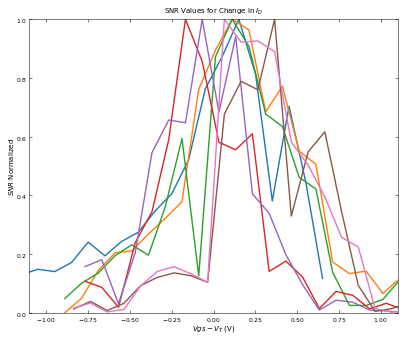

In [78]:
# define some AutoFlowStaticBias experiments that are good
SNR_experiment_names = [['C148FlowSaltWaterSNR/C148/G/35-36', 1, 'one'], 
                        ['C148Prelim/C148/G/17-18', 21, 'two'], 
                        ['C148FlowSaltWaterSNR/C148/A/9-10', 1, 'three'],
                        ['C148FlowSaltWaterSNR/C148/A/17-18', 1, 'four']]

'''
['C148FlowSaltWaterSNR/C148/G/24-25', 1, 'five'],
['C148FlowSaltWaterSNR/C148/G/47-48', 1, 'six'],
['C148FlowSaltWaterSNR/C148/A/4-5', 1, 'seven']
                
'''
colors = [mplu.setupColors(None, 20, colorMapName='white_teal_black', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='plasma', colorMapStart=0.5, colorMapEnd=0.18), 
          mplu.setupColors(None, 20, colorMapName='copper', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='winter', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greens', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Reds', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Greys', colorMapStart=0.5, colorMapEnd=0.18),
          mplu.setupColors(None, 20, colorMapName='Oranges', colorMapStart=0.5, colorMapEnd=0.18)]

fig1, ax1 = dpu.makeBlankPlot(figsize=(2.2*3,1.8*3))
ax1.set_ylabel('$ Signal-Noise Ratio $')
ax1.set_ylim(0, 1)
experiment_counter = -1
legend = []

initial_vt = 0
for SNR_experiment in SNR_experiment_names:
    experiment_counter = experiment_counter + 1
    device_directory = SNR_experiment[0]
    device_number = SNR_experiment[1]
    
    data_long_gatesweep = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'GateSweep.json', minExperiment=device_number, maxExperiment=device_number) 
    data_long_fsb       = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'FlowStaticBias.json', minExperiment=device_number, maxExperiment=device_number) 

    SNR = []
    SNR_averaged_cycles = []
    SNR_total = []
    SNR_total_std = []
    allVgs = []
    cycles_SNRs = []
    
    # calculate average threshold voltage
    Vts = []
    for direction in range(0, 2):
        both_Vts = []
        for i in range(int(len(data_long_gatesweep)/(4/1)), int(len(data_long_gatesweep)/(4/3))):
            vgs_data = data_long_gatesweep[i]['Results']['vgs_data'][direction]    
            id_data = data_long_gatesweep[i]['Results']['id_data'][direction]
            bias_metrics = fet_model.FET_Metrics(vgs_data, id_data)
            V_T = bias_metrics['V_T']
            both_Vts.append(V_T)
        Vts.append(np.median(both_Vts))
    Vt_average = np.mean(Vts)
    if experiment_counter == 0:
        initial_vt = np.mean(Vts)
        
    for i in range(len(data_long_fsb)):
        currentDevice = data_long_fsb[i]
        
        cycleCount = currentDevice["runConfigs"]["FlowStaticBias"]["cycleCount"]
        pumpPins = currentDevice["runConfigs"]["FlowStaticBias"]["pumpPins"]
        numberOfMotors = len(pumpPins)
        # this should be a constant value regardless
        currentVgs = np.mean(currentDevice["Results"]["vgs_data"]) 
        currentVds = np.mean(currentDevice["Results"]["vds_data"]) 
        
        # current data, with each index containing current data for each respective motor, in their own index for each cycle
        # id_data_total = [ [ [], [] ], [ [], [] ], [ [], [] ] ]
        # ^ with three cycles, with two motors
        id_data_total = []
        for cycleIndex in range(0, cycleCount):
            cycleArray = []
            for pinCount in range(0, numberOfMotors):
                cycleArray.append([])
            id_data_total.append(cycleArray)
        
        # go through pump_on_intervals_pin, add to proper id_data index based on where pin is
        counter = 0
        pinAlternatingCounter = 0
        measuredIdData = currentDevice["Results"]["id_data"]
        pump_on_intervals_pin = currentDevice["Results"]["pump_on_intervals_pin"]
        prevPin = pump_on_intervals_pin[0]

        for pumpIntervalCount in pump_on_intervals_pin:
            if prevPin != pumpIntervalCount:
                #print("counter: ", str(counter))
                pinAlternatingCounter += 1
                prevPin = pumpIntervalCount
                #print(int(pinAlternatingCounter / len(pumpPins)))
                
            variablename = int(pinAlternatingCounter / len(pumpPins))
            id_data_total[ variablename ][pumpPins.index(pumpIntervalCount)].append(measuredIdData[counter])
            counter += 1
        
        # calculate signal to noise ratio!
        # The assumption here is that the FIRST pin is the control
        
        # SNR: each index represents noise per cycle; each array in respective index represents SNR b/w control and 
        # solutions outputted from digitalPins as ordered in pumpPins
        SNR = []
        
        for cycleIndex in range(0, cycleCount):
            individualPumpRatio = []
            #print("cycle count: ", str(cycleIndex))
            # go through every other pin, compare to control
            for pinIndex in range(1, len(pumpPins)):
                control_data = id_data_total[cycleIndex][0]
                control_data = control_data[int(len(control_data)*1/4):int(len(control_data)*3/4)]
                other_data = id_data_total[cycleIndex][pinIndex]
                other_data = other_data[int(len(other_data)*1/4):int(len(other_data)*3/4)]
                
                u1 = np.mean(control_data)
                u2 = np.mean(other_data)
                #print("means")
                #print(u1, u2)
                
                control_data = np.array(control_data)
                other_data = np.array(other_data)
                
#                 plt.plot(control_data)
#                 plt.plot(other_data)
                
                xs = np.linspace(0,1,len(control_data))
                
                control_data -= np.poly1d(np.polyfit(xs, control_data, 2))(xs)
                other_data -= np.poly1d(np.polyfit(xs, other_data, 2))(xs)
                
#                 plt.plot(control_data + u1)
#                 plt.plot(other_data + u2)
#                 plt.show()
                
                signal = abs(u1 - u2)
                std1 = np.std(control_data)
                std2 = np.std(other_data)
                noise = (std1 + std2) / 2

                individualPumpRatio.append(signal / noise)
            SNR.append(individualPumpRatio)
#         print(SNR)
        
        # go through every possible pin combination (i), and average up the cycles (k)
        SNR_averaged_cycles = []
        SNR_averaged_cycles_std = []
        for j in range(0, len(pumpPins)-1):
            cycles_SNR = []
            for k in range(1, cycleCount):
                cycles_SNR.append(SNR[k][j])
            
            SNR_averaged_cycles.append(np.mean(cycles_SNR))
            SNR_averaged_cycles_std.append(np.std(cycles_SNR))
            
            SNR_total.append(SNR_averaged_cycles)
            SNR_total_std.append(SNR_averaged_cycles_std)
        
#         print(cycles_SNR)
        cycles_SNRs.append(cycles_SNR)
        allVgs.append(currentVgs)
    
    SNR_total = np.array(SNR_total)
    SNR_total /= np.max(SNR_total)
    
    cycles_SNRs = np.array(cycles_SNRs)
    for r in range(cycles_SNRs.shape[1]):
        cycles_SNRs[:,r] /= np.max(cycles_SNRs[1:-1,r])
    cycles_SNRs[cycles_SNRs > 1] -= 1
    
    allVgs = np.array(allVgs)
    
    for x in range(0, len(pumpPins)-1):
        correspondingSNR = []
        snr_max_per = 0
        snr_max_per_index = 0
#         ax1.plot(allVgs - Vt_average, SNR_total)
        ax1.plot(allVgs - Vt_average, cycles_SNRs)
        
#         ax1.errorbar(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1), yerr=np.std(cycles_SNRs, axis=1))
#         plt.fill_between(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1)-np.std(cycles_SNRs, axis=1), np.mean(cycles_SNRs, axis=1)+np.std(cycles_SNRs, axis=1), alpha=0.4)
        
#         avgStd = np.mean(np.std(cycles_SNRs, axis=1))
#         ax1.errorbar(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1), yerr=avgStd)
#         plt.fill_between(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1)-avgStd, np.mean(cycles_SNRs, axis=1)+avgStd, alpha=0.4)
        
        for y in range(0, len(allVgs)):
            correspondingSNR.append(SNR_total[y][x])
            #ax1.plot([allVgs[y] - (Vt_average)], [SNR_total[y][x]], color=colors[experiment_counter][0], linestyle=None, linewidth=0, marker='o', markersize=4)
            #ax1.errorbar([allVgs[y] - Vt_average], [SNR_total[y][x]], yerr=SNR_total_std[y][x], color=colors[experiment_counter][0], linewidth=1, capsize=2, capthick=0.5, elinewidth=0.5)
            if SNR_total[y][x] > snr_max_per:
                snr_max_per = SNR_total[y][x]
                snr_max_per_index = y
        #ax1.axvline(allVgs[snr_max_per_index])

file_name = 'SNRPlotNotebookTotal'
ax1.set_xlim(left=-1.1, right=1.1)
ax1.set_xlabel('$ Vgs - V_{{T}} $ (V)')
ax1.set_ylabel('$ SNR $ Normalized')
ax1.set_title('SNR Values for Change in $I_{{D}}$')
plt.show()
# dpu.saveExternalPlot(fig1, file_name)

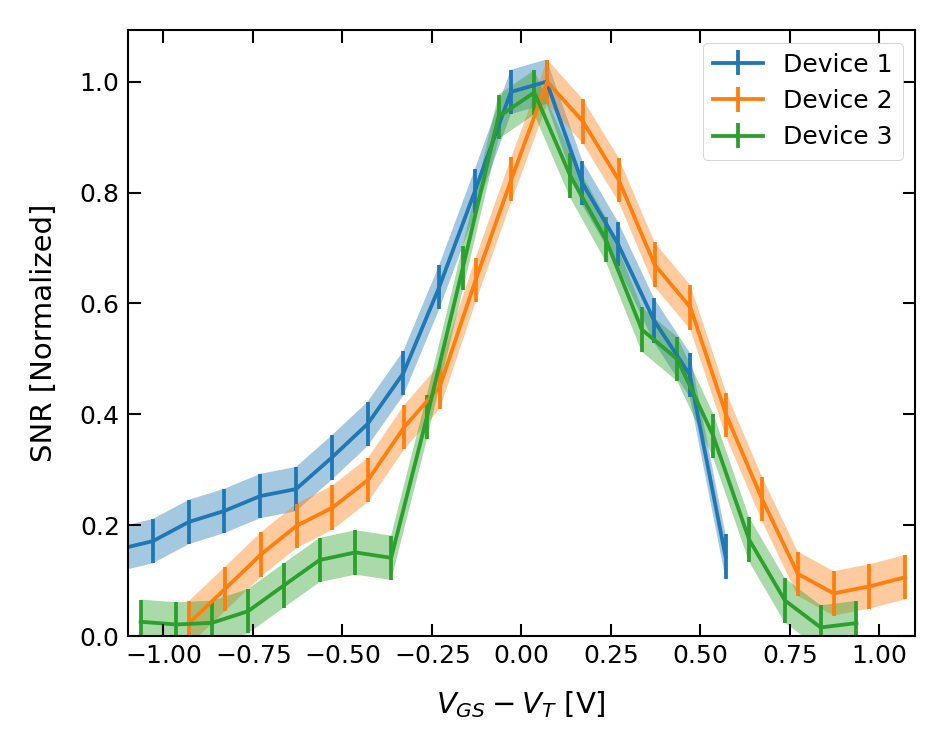

In [117]:
import scipy.signal

# define some AutoFlowStaticBias experiments that are good
SNR_experiment_names = [['C148FlowSaltWaterSNR/C148/G/35-36', 1, 'one'], 
                        ['C148Prelim/C148/G/17-18', 21, 'two'], 
                        #['C148FlowSaltWaterSNR/C148/A/9-10', 1, 'three'],
                        ['C148FlowSaltWaterSNR/C148/A/17-18', 1, 'four']]

'''
['C148FlowSaltWaterSNR/C148/G/24-25', 1, 'five'],
['C148FlowSaltWaterSNR/C148/G/47-48', 1, 'six'],
['C148FlowSaltWaterSNR/C148/A/4-5', 1, 'seven']
                
'''

fig1, ax1 = plt.subplots(figsize=(5*0.65, 4*0.65))
ax1.set_ylabel('$ Signal-Noise Ratio $')

experiment_counter = -1
legend = []

initial_vt = 0
for SNR_experiment in SNR_experiment_names:
    experiment_counter = experiment_counter + 1
    device_directory = SNR_experiment[0]
    device_number = SNR_experiment[1]
    
    data_long_gatesweep = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'GateSweep.json', minExperiment=device_number, maxExperiment=device_number) 
    data_long_fsb       = dlu.loadSpecificDeviceHistory('../../AutexysData/nathan/' + device_directory, 'FlowStaticBias.json', minExperiment=device_number, maxExperiment=device_number) 

    SNR = []
    SNR_averaged_cycles = []
    SNR_total = []
    SNR_total_std = []
    allVgs = []
    cycles_SNRs = []
    
    # calculate average threshold voltage
    Vts = []
    for direction in range(0, 2):
        both_Vts = []
        for i in range(int(len(data_long_gatesweep)/(4/1)), int(len(data_long_gatesweep)/(4/3))):
            vgs_data = data_long_gatesweep[i]['Results']['vgs_data'][direction]    
            id_data = data_long_gatesweep[i]['Results']['id_data'][direction]
            bias_metrics = fet_model.FET_Metrics(vgs_data, id_data)
            V_T = bias_metrics['V_T']
            both_Vts.append(V_T)
        Vts.append(np.median(both_Vts))
    Vt_average = np.max(Vts)
    if experiment_counter == 0:
        initial_vt = np.max(Vts)
        
    for i in range(len(data_long_fsb)):
        currentDevice = data_long_fsb[i]
        
        cycleCount = currentDevice["runConfigs"]["FlowStaticBias"]["cycleCount"]
        pumpPins = currentDevice["runConfigs"]["FlowStaticBias"]["pumpPins"]
        numberOfMotors = len(pumpPins)
        # this should be a constant value regardless
        currentVgs = np.mean(currentDevice["Results"]["vgs_data"]) 
        currentVds = np.mean(currentDevice["Results"]["vds_data"]) 
        
        # current data, with each index containing current data for each respective motor, in their own index for each cycle
        # id_data_total = [ [ [], [] ], [ [], [] ], [ [], [] ] ]
        # ^ with three cycles, with two motors
        id_data_total = []
        for cycleIndex in range(0, cycleCount):
            cycleArray = []
            for pinCount in range(0, numberOfMotors):
                cycleArray.append([])
            id_data_total.append(cycleArray)
        
        # go through pump_on_intervals_pin, add to proper id_data index based on where pin is
        counter = 0
        pinAlternatingCounter = 0
        measuredIdData = currentDevice["Results"]["id_data"]
        pump_on_intervals_pin = currentDevice["Results"]["pump_on_intervals_pin"]
        prevPin = pump_on_intervals_pin[0]

        for pumpIntervalCount in pump_on_intervals_pin:
            if prevPin != pumpIntervalCount:
                #print("counter: ", str(counter))
                pinAlternatingCounter += 1
                prevPin = pumpIntervalCount
                #print(int(pinAlternatingCounter / len(pumpPins)))
                
            variablename = int(pinAlternatingCounter / len(pumpPins))
            id_data_total[ variablename ][pumpPins.index(pumpIntervalCount)].append(measuredIdData[counter])
            counter += 1
        
        # calculate signal to noise ratio!
        # The assumption here is that the FIRST pin is the control
        
        # SNR: each index represents noise per cycle; each array in respective index represents SNR b/w control and 
        # solutions outputted from digitalPins as ordered in pumpPins
        SNR = []
        
        for cycleIndex in range(0, cycleCount):
            individualPumpRatio = []
            #print("cycle count: ", str(cycleIndex))
            # go through every other pin, compare to control
            for pinIndex in range(1, len(pumpPins)):
                control_data = id_data_total[cycleIndex][0]
                control_data = control_data[int(len(control_data)*1/4):int(len(control_data)*3/4)]
                other_data = id_data_total[cycleIndex][pinIndex]
                other_data = other_data[int(len(other_data)*1/4):int(len(other_data)*3/4)]
                
                u1 = np.mean(control_data)
                u2 = np.mean(other_data)
                #print("means")
                #print(u1, u2)
                
                control_data = np.array(control_data)
                other_data = np.array(other_data)
                
#                 plt.plot(control_data)
#                 plt.plot(other_data)
                
                xs = np.linspace(0,1,len(control_data))
                
                control_data -= np.poly1d(np.polyfit(xs, control_data, 2))(xs)
                other_data -= np.poly1d(np.polyfit(xs, other_data, 2))(xs)
                
#                 plt.plot(control_data + u1)
#                 plt.plot(other_data + u2)
#                 plt.show()
                
                signal = abs(u1 - u2)
                std1 = np.std(control_data)
                std2 = np.std(other_data)
                noise = (std1 + std2) / 2

                individualPumpRatio.append(signal / noise)
            SNR.append(individualPumpRatio)
#         print(SNR)
        
        # go through every possible pin combination (i), and average up the cycles (k)
        SNR_averaged_cycles = []
        SNR_averaged_cycles_std = []
        for j in range(0, len(pumpPins)-1):
            cycles_SNR = []
            for k in range(1, cycleCount):
                cycles_SNR.append(SNR[k][j])
            
            SNR_averaged_cycles.append(np.mean(cycles_SNR))
            SNR_averaged_cycles_std.append(np.std(cycles_SNR))
            
            SNR_total.append(SNR_averaged_cycles)
            SNR_total_std.append(SNR_averaged_cycles_std)
        
#         print(cycles_SNR)
        cycles_SNRs.append(cycles_SNR)
        allVgs.append(currentVgs)
    
    SNR_total = np.array(SNR_total)
    SNR_total /= np.max(SNR_total)
    
    cycles_SNRs = np.array(cycles_SNRs)
    for r in range(cycles_SNRs.shape[1]):
        cycles_SNRs[:,r] /= np.max(cycles_SNRs[1:-1,r])
    cycles_SNRs[cycles_SNRs > 1] -= 1
    
    for r in range(cycles_SNRs.shape[1]):
        cycles_SNRs[:,r] = scipy.signal.savgol_filter(cycles_SNRs[:,r], 3, 1)
    
    for r in range(cycles_SNRs.shape[1]):
        cycles_SNRs[:,r] /= np.max(cycles_SNRs[1:-1,r])
    
    allVgs = np.array(allVgs)
    
    for x in range(0, len(pumpPins)-1):
        correspondingSNR = []
        snr_max_per = 0
        snr_max_per_index = 0
#         ax1.plot(allVgs - Vt_average, SNR_total)
#         ax1.plot(allVgs - Vt_average, cycles_SNRs)
        
#         ax1.errorbar(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1), yerr=np.std(cycles_SNRs, axis=1))
#         plt.fill_between(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1)-np.std(cycles_SNRs, axis=1), np.mean(cycles_SNRs, axis=1)+np.std(cycles_SNRs, axis=1), alpha=0.4)
        
        avgStd = max([0.04, np.mean(np.std(cycles_SNRs, axis=1))])
        
        ax1.errorbar(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1), yerr=avgStd, label=f"Device {experiment_counter+1}")
        plt.fill_between(allVgs - Vt_average, np.mean(cycles_SNRs, axis=1)-avgStd, np.mean(cycles_SNRs, axis=1)+avgStd, alpha=0.4)
        
        for y in range(0, len(allVgs)):
            correspondingSNR.append(SNR_total[y][x])
            #ax1.plot([allVgs[y] - (Vt_average)], [SNR_total[y][x]], color=colors[experiment_counter][0], linestyle=None, linewidth=0, marker='o', markersize=4)
            #ax1.errorbar([allVgs[y] - Vt_average], [SNR_total[y][x]], yerr=SNR_total_std[y][x], color=colors[experiment_counter][0], linewidth=1, capsize=2, capthick=0.5, elinewidth=0.5)
            if SNR_total[y][x] > snr_max_per:
                snr_max_per = SNR_total[y][x]
                snr_max_per_index = y
        #ax1.axvline(allVgs[snr_max_per_index])

file_name = 'SNRPlotNotebookTotal'
ax1.set_xlim(left=-1.1, right=1.1)
ax1.set_ylim(ymin=0)
ax1.legend()
ax1.set_xlabel('$ V_{{GS}} - V_{{T}} $ [V]')
ax1.set_ylabel('SNR [Normalized]')
plt.tight_layout()
plt.show()
# dpu.saveExternalPlot(fig1, file_name)